# Predicting Bike Rentals

## Introduction

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

Here are the descriptions for the relevant columns:

* instant - A unique sequential ID number for each row
* dteday - The date of the rentals
* season - The season in which the rentals occurred
* yr - The year the rentals occurred
* mnth - The month the rentals occurred
* hr - The hour the rentals occurred
* holiday - Whether or not the day was a holiday
* weekday - Whether or not the day was a weekday
* workingday - Whether or not the day was a working day
* weathersit - The weather (as a categorical variable)
* temp - The temperature, on a 0-1 scale
* atemp - The adjusted temperature
* hum - The humidity, on a 0-1 scale
* windspeed - The wind speed, on a 0-1 scale
* casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
* registered - The number of registered riders (people who had already signed up)
* cnt - The total number of bike rentals (casual + registered)

We'll try to predict the total number of bikes people rented in a given hour.

## Reading in and exploring the data

In [302]:
#importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [303]:
#reading in bike_rental_hour.csv as a pandas dataframe
bike_rentals = pd.read_csv('bike_rental_hour.csv')

In [304]:
#displaying the first five rows of the bike_rentals dataframe
print(bike_rentals.head())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


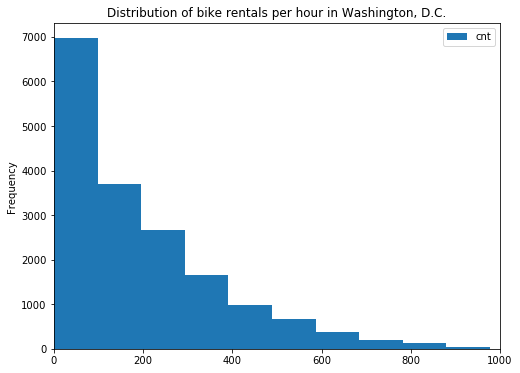

In [305]:
#plotting the histogram of bike rentals per hour column
bike_rentals.plot(y='cnt', kind='hist', title='Distribution of bike rentals per hour in Washington, D.C.', \
                  xlim=(0,1000), figsize=(8,6))
plt.show()

In [306]:
#computing some descriptive stats of bike rentals per hr
bike_rentals['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

In [307]:
#computing correlations between the bike rentals per hour and the other columns
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

## Calculating features

In [308]:
#creating a function to take in a numerical value of hour and return a categorical value
def assign_label(hr_num):
    hr_dict = {
        1: [6, 12],
        2: [12, 18],
        3: [18, 24],
        4: [0, 6]
    }
    for key in hr_dict:
        if hr_num >= hr_dict[key][0] and hr_num <= hr_dict[key][1]:
            return key

In [309]:
#applying the above function to the hr column in bike_rentals
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

In [310]:
#validating the correct execution of numeric to categorical conversion of hr
bike_rentals[['hr','time_label']].head()

,hr,time_label
0,0,4
1,1,4
2,2,4
3,3,4
4,4,4


## Selecting an error metric

Mean Squared Error (MSE) or Mean Absolute Error (MAE) are good error metrics to measure prediction performance for this particular continuous dataset. Though MAE is easily interpretable, MSE penalizes more for inaccuracies. Let's go ahead with MSE as the error metric.

## Randomly selecting training and test data

In [311]:
#assigning 80% of a randomly sampled bike_rentals dataset to train and rest 20% to test
train = bike_rentals.sample(frac=0.8, random_state=5)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

In [312]:
#displaying the first five rows of the train dataframe
print(train.head())

       instant      dteday  season  yr  mnth  hr  holiday  weekday  \
4707      4708  2011-07-20       3   0     7   1        0        3   
13755    13756  2012-08-01       3   1     8   8        0        3   
10794    10795  2012-03-30       2   1     3  21        0        5   
7665      7666  2011-11-21       4   0    11   0        0        1   
9751      9752  2012-02-16       1   1     2   6        0        4   

       workingday  weathersit  temp   atemp   hum  windspeed  casual  \
4707            1           1  0.70  0.6667  0.84     0.0000       4   
13755           1           2  0.66  0.6061  0.78     0.1940      32   
10794           1           1  0.38  0.3939  0.66     0.1343      30   
7665            1           2  0.46  0.4545  0.94     0.0000       4   
9751            1           2  0.30  0.3182  0.70     0.0896       4   

       registered  cnt  time_label  
4707            7   11           4  
13755         649  681           1  
10794         190  220           3 

In [313]:
#displaying the first five rows of the test dataframe
print(test.head())

    instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
3         4  2011-01-01       1   0     1   3        0        6           0   
10       11  2011-01-01       1   0     1  10        0        6           0   
16       17  2011-01-01       1   0     1  16        0        6           0   
18       19  2011-01-01       1   0     1  18        0        6           0   
22       23  2011-01-01       1   0     1  22        0        6           0   

    weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  \
3            1  0.24  0.2879  0.75     0.0000       3          10   13   
10           1  0.38  0.3939  0.76     0.2537      12          24   36   
16           2  0.42  0.4242  0.82     0.2985      41          52   93   
18           3  0.42  0.4242  0.88     0.2537       9          26   35   
22           2  0.40  0.4091  0.94     0.2239      11          17   28   

    time_label  
3            4  
10           1  
16           2  
18          

## Predictions using Linear Regression

In [314]:
#importing LinearRegression and mean_squared_error classes from scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [315]:
#selecting features for the linear regression model, predicting bike rentals per hour and measuring model accuracy
predictor_columns = ['season','yr','hr','temp','hum']

lr = LinearRegression()
lr.fit(train[predictor_columns], train['cnt'])
test['lr_cnt_predictions'] = lr.predict(test[predictor_columns])

mse_lr = mean_squared_error(test['cnt'], test['lr_cnt_predictions'])
print(mse_lr)

19059.3491801


/Users/jeganram/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The MSE is pretty high due to the fact that counts are mostly lower, but with a few very high values i.e. the data is skewed. MSE penalizes large errors.

## Predictions using Decision Trees

In [316]:
#importing DecisionTreeRegressor class from scikit-learn
from sklearn.tree import DecisionTreeRegressor

In [317]:
#making predictions using decision trees and measuring prediction error for evaluation
dt = DecisionTreeRegressor(max_depth=11, min_samples_leaf=7)
dt.fit(train[predictor_columns], train['cnt'])
test['dt_cnt_predictions'] = dt.predict(test[predictor_columns])

mse_dt = mean_squared_error(test['cnt'], test['dt_cnt_predictions'])
print(mse_dt)

7703.46436753


/Users/jeganram/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The prediction error has considerably reduced after using the decision tree model that takes into account the non-linearity in the data.

## Predictions using Random Forests

In [318]:
#importing DecisionTreeRegressor class from scikit-learn
from sklearn.ensemble import RandomForestRegressor

In [319]:
#making predictions using random forests and measuring prediction error for evaluation
rf = RandomForestRegressor(n_estimators=56, max_depth=12, min_samples_leaf=6, max_features=3 ,random_state=8)
rf.fit(train[predictor_columns], train['cnt'])
test['rf_cnt_predictions'] = rf.predict(test[predictor_columns])

mse_rf = mean_squared_error(test['cnt'], test['rf_cnt_predictions'])
print(mse_rf)

7169.31287327


/Users/jeganram/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The prediction error using random forests is relatively less than decision trees due to reduction in overfitting.

## Potential next steps

* Calculate additional features, such as an index combining temperature, humidity, and wind speed.
* Try predicting casual and registered instead of cnt.